# Estudo de um Modelo Difusivo para a Absorção de Água por Sementes

por [Afrânio Melo](http://afrjr.weebly.com) (t.c.c. Afra)

[afraeq@gmail.com](mailto:afrjr3@gmail.com)


07/2017

### Resumo

Neste [notebook Jupyter](http://jupyter.org/), estudaremos um modelo difusivo proposto por [HSU (1984)](http://www.fcfar.unesp.br/arquivos/560524.pdf) para descrever o movimento de água dentro de sementes durante o processo de hidratação, que encontra diversas aplicações no cotidiano e nas indústrias agrícola e de alimentos. As equações diferenciais parciais do balanço de massa serão discretizadas e resolvidas numericamente, fornecendo como resultado a concentração de água na semente em função da posição e do tempo - ou seja, o resultado será a função $C(x,t)$. Diversos métodos de visualização do resultado serão descritos, incluindo uma animação em vídeo. A título de ilustração de uma aplicação, utilizaremos o modelo para correlacionar dados experimentais de absorção de água por sementes de pinhão manso medidos por [EVENCIO *et al.* (2011)](http://www.scielo.br/pdf/rarv/v35n2/a03v35n2.pdf).

As técnicas numéricas ilustradas neste *notebook* incluem discretização de equações diferenciais parciais, resolução de sistemas de equações diferenciais ordinárias, integração numérica e estimação de parâmetros. Os códigos estão escritos na linguagem [Python 3.6](https://www.python.org/) e utilizam as bibliotecas [NumPy](http://www.numpy.org/), [SciPy](https://www.scipy.org/) e [Matplotlib](https://matplotlib.org/).

<img src="https://www.vegetariantimes.com/.image/c_limit%2Ccs_srgb%2Cq_80%2Cw_960/MTQ2ODI5MzI5MDM5NDM1NzM2/how-to-soak-and-sprout-nuts-seeds-grains-and-beansjpg.jpg" width="500"/>

## 1. Contextualização

Imagine que você esteja saindo com esta garota:

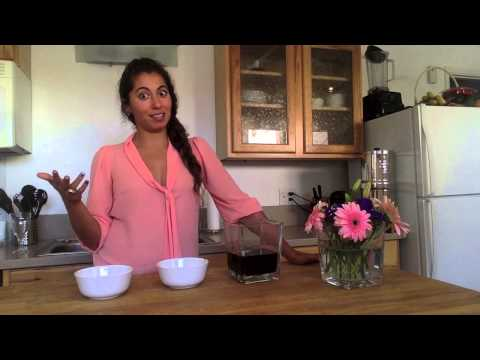

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("pthIRkUsNLc")

Se você prefere garotos, imagine este:

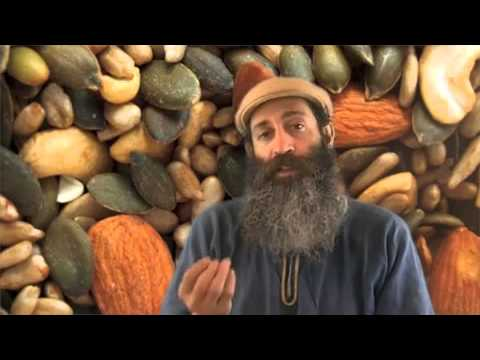

In [2]:
YouTubeVideo("9jAkRSkdtzs")

Como se nota nos vídeos, ambos os seus prováveis pretendentes dão bastante importância ao processo de hidratação de grãos, sementes e legumes. E eles têm razão em seu entusiasmo! No aspecto nutricional, a hidratação realça o sabor, auxilia na absorção dos nutrientes pelo nosso organismo e remove os antinutrientes, dentre outras vantagens. A hidratação também encontra muitas aplicações nas indústrias agrícola e de alimentos, como no processo de parboilização do arroz, por exemplo.

Todo esse entusiasmo fez você se apaixonar. E, como todo ser apaixonado, você está à procura de uma maneira para impressionar sua pretendente. Passa o dia tentando lembrar de alguma habilidade sua que possa ser usada para maravilhar alguém. Escrever poemas? Não é seu forte. Comprar flores? Nada mais brega. Cartas de amor? Suas notas de Redação nunca foram boas.

Quando você começa a achar que não sabe fazer nada de bom e está prestes a colocar Maiara & Maraísa para escutar chorando a noite toda, eis que surge a lembrança do seu último grande sucesso na vida: aquele DEZ na prova de Transferência de Massa, que deixou a turma inteira morrendo de inveja! E o melhor: Transferência de Massa tem tudo a ver com hidratação de grãos, sementes e legumes!

Uau, vocês foram feitos um para o outro!

Você finalmente traça seu plano. Utilizando um modelo difusivo baseado na lei de Fick com difusividade dependente da concentração, você irá preparar para sua amada um presente em forma de animação em vídeo, ilustrando como ocorre o movimento de água dentro das sementes durante o processo de hidratação.

Fala sério. Qualquer um morreria de amores com um presente desses. Você se anima cada vez mais, pega o caderno da disciplina, abre o prompt do Python e começa a trabalhar freneticamente.

Mãos à obra, pois o amor não sabe esperar!

## 2. O modelo

### 2.1 O balanço material

Seu objetivo é calcular como a concentração de água varia em função da posição e do tempo no interior das sementes.

O ponto de partida é a velha conhecida equação de balanço material:

$$\verb! Acúmulo = Entrada - Saída + Geração!$$

Aplicada a um componente $A$ em um volume de controle diferencial, a equação de balanço material toma a forma ([WELTY et al., 2017](https://www.amazon.com.br/Fundamentos-Transfer%C3%AAncia-Momento-Calor-Massa/dp/8521634188?tag=goog0ef-20&smid=A1ZZFT5FULY4LN&ascsubtag=8521634188)):

$$\frac{\displaystyle\partial\,C_A}{\partial t } = - \nabla \cdot \mathbf{N}_{A} + R_A$$

sendo:

* $C_A$ a concentração do componente $A$, em mol/volume;
* $\mathbf{N}_{A}$ o fluxo molar de $A$, em mol/(tempo$\cdot$área);
* $R_A$ a taxa de geração do componente $A$, em mol/(tempo$\cdot$volume);
* $\nabla \cdot $ o operador divergência, do Cálculo Diferencial.

Nessa importante forma, $\displaystyle\frac{\partial\,C_A}{\partial t }$ corresponde ao acúmulo, $- \nabla \cdot \mathbf{N}_{A}$ corresponde à entrada menos a saída e $R_A$ corresponde à geração.

Como o volume de controle em questão é diferencial, devemos integrar a equação de balanço ao longo de todo o volume da semente para obter a evolução da concentração com o tempo em todos os pontos da semente. Porém, antes é preciso:

* enunciar hipóteses referentes ao sistema físico considerado (no caso, nossas sementinhas);
* identificar condicões inicial (CI) e de contorno (CC) apropriadas;
* tornar o modelo adimensional por meio de uma mudança de variáveis;
* discretizar a equação para que possa ser implementada e resolvida em computador.

### 2.2 Hipóteses

As hipóteses referentes à situação física específica são:

* 1) as sementes são esféricas, portanto, o sistema de coordenadas usado é esférico;

* 2) a difusão é unidimensional (ocorre apenas na direção radial);

* 3) não há geração de água na semente, portanto, $R_A = 0$;

* 4) as concentrações de água são baixas: nesse caso, a relação entre fluxo $N_{A}$ e concentração ${C}_{A}$ pode ser expressa pela Lei de Fick: $N_{A} = - D_{AB} \, \partial C_A/\partial r $, sendo $D_{AB}$ a difusividade de $A$ no meio $B$. A difusividade é uma medida da rapidez com que o componente $A$ (água) se difunde no meio $B$ (semente).

Sendo assim, a equação de balanço de massa se torna:

$$\frac{\partial C_A}{\partial t} = \frac{1}{r^2} \frac{\partial}{\partial r} (r^2 D_{AB} \frac{\partial C_A}{\partial r })$$

[HSU (1984)](http://www.fcfar.unesp.br/arquivos/560524.pdf) propôs uma dependência exponencial da difusividade $D_{AB}$ em relação à concentração:

$$D_{AB} = D_0\,e^{\,\kappa C_A}$$

sendo $D_0$ e $\kappa$ parâmetros a serem ajustados a dados experimentais.

### 2.3 Condições inicial e de contorno

Lembre-se de que para resolver uma equação diferencial parcial (EDP), é necessário identificar condições iniciais (CI) e de contorno (CC) apropriadas. Muitas vezes, essa é a parte mais difícil da resolução do problema.

[HSU (1984)](http://www.fcfar.unesp.br/arquivos/560524.pdf) propôs a seguinte CI:

$$ C_A = C_{A0} \,\,\,\forall r, \,\,\, t = 0$$ 

e as seguintes CC's:

$$ \frac{\partial C_A}{\partial r} = 0, \,\,\, r = 0, \,\,\, t> 0 $$

$$ C_A = [1-\exp(-\beta t)] C_{As} + C_{A0} \exp(-\beta t), \,\,\, r=1, \,\,\, t>0$$

sendo $C_{As}$ a concentração de água na saturação, ou seja, a máxima concentração de água na semente.

A CI especifica simplesmente que, no tempo $t=0$, a concentração de água na semente apresenta um valor inicial $C_{A0}$ em todos os pontos. A primeira CC resulta da simetria do sistema de coordenadas esférico. A segunda CC indica que a variação da concentração na superfície da semente é dada por um processo de primeira ordem, com constante de taxa $\beta$ a ser ajustada a dados experimentais. 

As grandes novidades introduzidas pelo modelo proposto por [HSU (1984)](http://www.fcfar.unesp.br/arquivos/560524.pdf) estão na dependência exponencial da difusividade $D_{AB}$ com a concentração e na forma da segunda CC acima.

### 2.4 Adimensionalização do modelo

Colocar o modelo na forma adimensional (em que suas variáveis não possuem dimensão) é conveniente porque nos permite estudar o modelo sem a preocupação com detalhes como dimensões ou unidades.

Para adimensionalizar uma EDP, é necessário recorrer ao artifício da mudança de variáveis. [HSU (1984)](http://www.fcfar.unesp.br/arquivos/560524.pdf) propôs as seguintes mudanças:

$$S = \int_0^{C_A^*} D\, dC_A^* = \frac{\exp\,(kC_A^*-1)}{k} $$

$$R = \frac{r}{a}$$

$$T = \frac{D^{'}_0 t}{a^2}$$

sendo:

$$C_A^* = \frac{C_A-C_{A0}}{C_{As}-C_{A0}}$$

$$k = \kappa (C_{As}-C_{A0})$$

$$D = \frac{D_{AB}}{D^{'}_0}$$

$$D^{'}_0 = D_0\,\exp(\kappa C_{A0})$$

com $a$ denotando o raio da semente. Atenção para a diferença entre $k$ (ká) e $\kappa$ (kapa).

Após a mudança de variáveis, o modelo completo (EDP + CI e CC's) adimensional toma a forma:

$$ \frac{\partial S}{\partial T} = D \left(\displaystyle\frac{\partial^2 S}{\partial R^2} + \frac{2}{R} \displaystyle\frac{\partial S}{\partial R} \right) $$

$$ S = 0 \,\,\,\forall R, \,\,\, T = 0$$ 

$$ \frac{\partial S}{\partial R} = 0, \,\,\, R = 0, \,\,\, T> 0 $$

$$ S = \frac{1}{k}\,[\exp\,(k\,(1-\exp(-B T)))-1], \,\,\, R=1, \,\,\, T>0$$

sendo $B = \beta a^2/D^{'}_0$.

Ufa! Deu trabalho, mas no final as equações ficaram mais simples.

### 2.5 Discretização do modelo

Nosso modelo  encontra-se na forma contínua. Lembre-se, entretanto, de que computadores trabalham apenas com dados discretos. Para que possamos implementar o modelo no computador, é preciso transformá-lo da forma contínua para a forma discreta. Isso é feito por meio da aproximação das derivadas espaciais por diferenças finitas (assunto estudado em Cálculo Numérico). As aproximações a serem feitas aqui serão:

$$\frac{\partial S}{\partial R} \approx \frac{S_{i+1}-S_i}{\delta R}$$

$$\frac{\partial^2 S}{\partial R^2} \approx \frac{S_{i+1}-2S_i+S_{i-1}}{(\delta R)^2}$$

Quanto menor o valor de $\delta R$, mais acurada é a representação da derivada por diferenças finitas (e mais custoso computacionalmente é o cálculo). Quando $\delta R \rightarrow 0$ (o que é impossível em um computador), a aproximação torna-se exata.

Aplicando as aproximações, a EDP se transforma no seguinte sistema de equações diferenciais ordinárias EDO's:

$$\frac{dS_i}{dT} = (k S_i + 1) \left[\frac{S_{i+1}-2S_i+S_{i-1}}{(\delta R)^2}+\frac{2}{(i-1) \delta R}\left(\frac{S_{i+1}-S_i}{\delta R}\right)\right]$$

E as CI e CC's tomam a forma:

$$ S_i = 0 \,\,\,\forall R, \,\,\, T = 0, \,\,\, i=1,...,n+1$$ 

$$ S_1 = S_2, \,\,\, R = 0, \,\,\, T> 0 $$

$$ S_{n+1} = \frac{1}{k}\,[\exp\,(k\,(1-\exp(-B T)))-1], \,\,\, R=1, \,\,\, T>0$$

É conveniente colocar as CC's na mesma forma que as EDO, ou seja, na forma $dS/dT = ...$ Derivando as duas CC's em relação à T, obtemos:

$$ \frac{dS_1}{dT} = \frac{dS_2}{dT}, \,\,\, R = 0, \,\,\, T> 0 $$

$$ \frac{dS_{n+1}}{dT} = B\,(\exp[k(1-\exp(-B T))-BT]), \,\,\, R=1, \,\,\, T>0$$

Ou seja, o modelo completo (EDO's + CI e CC's) na forma que será implementada computacionalmente em linguagem Python é:

$$\frac{dS_i}{dT} = (k S_i + 1) \left[\frac{S_{i+1}-2S_i+S_{i-1}}{(\delta R)^2}+\frac{2}{(i-1) \delta R}\left(\frac{S_{i+1}-S_i}{\delta R}\right)\right], \,\,\, i=2,...,n$$

$$ S_i = 0 \,\,\,\forall R, \,\,\, T = 0, \,\,\, i=1,...,n+1$$ 

$$ \frac{dS_1}{dT} = \frac{dS_2}{dT}, \,\,\, R = 0, \,\,\, T> 0 $$

$$ \frac{dS_{n+1}}{dT} = B\,(\exp[k(1-\exp(-B T))-BT]), \,\,\, R=1, \,\,\, T>0$$

Caso você tenha alguma dúvida quanto à discretização ou quanto à aproximação por diferenças finitas, consulte um livro de Cálculo Numérico ou dê uma olhada no último exemplo do curso [Introdução ao MATLAB para Engenharia](https://drive.google.com/file/d/0B2327zMqaoikNF91Y3AxTjYweUU/view) e no [código correspondente](https://drive.google.com/file/d/0B2327zMqaoikN2pmXzNtMHBianc/view), em que o procedimento é apresentado com mais detalhes.

O coração bate cada vez mais forte... Sem mais delongas, vamos à implementação!

## 3. Implementação do modelo

Chegou a hora de implementar o sistema discretizado de EDO's obtido na Seção anterior. A título de teste, o sistema será resolvido de modo a reproduzir a Figura 2 apresentada em [HSU (1984)](http://www.fcfar.unesp.br/arquivos/560524.pdf). Nessa figura, são traçados perfis de concentração $C_A^{*}$ em função do raio adimensional $R$ para alguns instantes de tempo adimensional $T$ selecionados.

Antes de mais nada, vamos importar de uma vez todos módulos a serem utilizados no decorrer do texto:

In [3]:
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import simps
from pyswarm import pso
from IPython.display import HTML
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc, animation, cm
%matplotlib inline

Lembre-se de que, após a discretização, o modelo tomou a forma de um sistema de EDO's. Esse sistema deve ser implementado em Python por meio de uma função, aqui chamada de **dSdT**. A função deve aceitar os valores das variáveis *S* e *T* (na forma de vetores), os parâmetros $k$ e $B$ e o número de pontos $n$ no domínio espacial (o valor do intervalo $\delta R$, a distância entre os pontos, é calculado a partir de $n$ por meio da relação $\delta R = 1/n$). O valor retornado pela função deve ser um vetor com os valores $dS_i/dT$ para todos os pontos $i$ do domínio espacial.

Segue a função **dSdT**:

In [4]:
# sistema de EDO's
def dSdT (S,T,k,B,n):
    
    # vetor que será retornado
    dS = np.zeros(n+1)
    
    # comprimento de cada intervalo
    deltaR = 1/n
    
    # EDO's propriamente ditas
    for i in range(1,n):
        dS[i] = (k*S[i]+1)*((S[i+1]-2*S[i]+S[i-1])/(deltaR**2)+(2/(i*deltaR))*(S[i+1]-S[i])/(deltaR))

    # condicões de contorno    
    dS[0] = dS[1]
    dS[n] = B*np.exp(k*(1-np.exp(-B*T))-B*T)
    
    return dS

Perceba que, no modelo, $dS/dT$ depende apenas de $S$ e não de $T$. Apesar disso, no código, a função é escrita como dependente de $S$ e $T$ (nessa ordem!), um requerimento necessário para compatibilidade com o *solver* de EDO's  [odeint](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.integrate.odeint.html), que usaremos adiante. 

Definimos a seguir os valores arbitrários dos parâmetros, os mesmos utilizados por [HSU (1984)](http://www.fcfar.unesp.br/arquivos/560524.pdf):


In [5]:
# parâmetros

k = 1.0
B = 286.2
n = 20         # número de pontos na discretização espacial

Para resolver o sistema de EDO's, é preciso especificar a condição inicial e a faixa de valores de $T$ em que $S$ será obtida:

In [6]:
# condição inicial
S_inicial = np.zeros(n+1)

# faixa de valores de T em que S será obtida
T = np.arange(0.0,0.15,1e-4)

Tudo preparado! Hora de resolver o sistema de EDO's. Para isso, usamos a função [odeint](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.integrate.odeint.html), importada da biblioteca [SciPy](https://www.scipy.org/):

In [7]:
# integrando!
sol = odeint(dSdT, S_inicial, T, args=(k,B,n))

Pronto! As EDO's foram resolvidas e o resultado, armazenado na variável **sol**. O próximo conjunto de comandos utiliza esse resultado para reproduzir a Figura 2 apresentada por [HSU (1984)](http://www.fcfar.unesp.br/arquivos/560524.pdf).

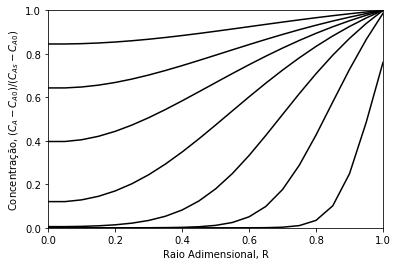

In [8]:
# convertendo S para concentração C*
C_star = np.log(k*sol+1)/k

# criando vetor para grid em R
R = np.linspace(0.0,1.0,n+1)

# pontos de T que serão plotados (iguais aos do artigo)
T_param = np.array([0.005, 0.015, 0.03, 0.05, 0.07, 0.09, 0.12])

# plotando

for j in range(len(C_star)):
    if any(abs(T_param-T[j])<1e-8):
        plt.plot(R,C_star[j,:],'-k')
        
plt.axis([0,1,0,1])
plt.xlabel('Raio Adimensional, R')
plt.ylabel('Concentração, $(C_A-C_{A0})/(C_{As}-C_{A0})$');

Ficou bonita! Igualzinha à do artigo. Cada uma dessas curvas representa o perfil de concentração na semente em dado instante de tempo $T$. Conforme o tempo passa, os valores das concentrações aumentam e se aproximam cada vez mais de 1. Esse aumento se dá mais rapidamente próximo à superfície (ou seja, para valores de $R$ mais altos). Eventualmente, quando $T \rightarrow \infty$, $C_A \rightarrow 1$ para todos os pontos $R$. 

"Só isso já seria suficiente para impressionar minha paixão", você pensa, aos suspiros. Mas você quer mais! Que tal plotar uma projeção polar do resultado em um certo instante de tempo (por exemplo, $T = 0{,}04$)?

O primeiro passo é criar matrizes que representem o domínio em $R$ e $\theta$ (coordenadas polares) e a imagem em $C^*$. Isso é feito com auxílio dos comandos [meshgrid](https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html) e [tile](https://docs.scipy.org/doc/numpy/reference/generated/numpy.tile.html), da biblioteca [NumPy](http://www.numpy.org/):

In [9]:
max_theta = 2.0 * np.pi
theta = np.linspace(0.0, max_theta, 100)

grid_R, grid_theta = np.meshgrid(R, theta)

grid_C_star = np.tile(C_star[400,:],(len(theta),1))

print(np.shape(grid_R))
print(np.shape(grid_theta))
print(np.shape(grid_C_star))

(100, 21)
(100, 21)
(100, 21)


Perceba que as três matrizes **grid_R**, **grid_theta** e **grid_C_star** têm a mesma dimensão.

Os próximos comandos geram um gráfico de projeção polar da nossa sementinha para o instante de tempo adimensional $T = 0{,}04$:

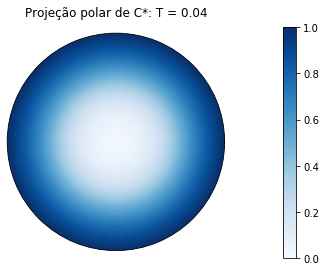

In [10]:
# criando a janela em que será plotada a projeção polar
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))

# plotando!
p1 = ax.contourf(grid_theta, grid_R, grid_C_star, 100, vmin=0, vmax=1, cmap=cm.Blues)

# removendo as marcações nos eixos R e theta
ax.set_xticklabels([])
ax.set_yticklabels([])

# removendo a grade
ax.grid(False)

# título
ax.set_title('Projeção polar de C*: T = %.2f'%(T[400]))

# obtendo os limites do mapa de cores
vmin,vmax = p1.get_clim()

# definindo uma escala normalizada
cNorm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

# criando um novo eixo no canto direito para plotar a barra de cores
ax3 = fig.add_axes([0.9, 0.1, 0.03, 0.8])

# plotando o mapa de cores no eixo recém-criado
cb1 = mpl.colorbar.ColorbarBase(ax3, norm=cNorm,cmap=cm.Blues)

# mostrando a figura!
plt.show()

Bonitinho, né?

Mas você não está satisfeito. O amor merece mais. Já que sabemos plotar a projeção polar para um instante de tempo específico (no caso, $T = 0{,}04$), será que conseguimos criar uma animação que mostre a evolução dessa projeção desde o instante inicial $T = 0$ até um $T$ final especificado?

Claro que sim! O primeiro passo é plotar uma projeção no instante $T = 0$:

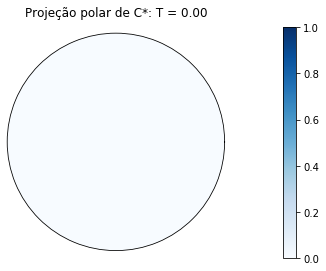

In [11]:
# definindo grid em C* para T = 0
grid_C_star = np.tile(C_star[0,:],(len(theta),1))

# criando a janela em que será plotada a projeção polar
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))

# plotando!
p1 = ax.contourf(grid_theta, grid_R, grid_C_star, 100, vmin=0, vmax=1, cmap=cm.Blues)

# removendo as marcações nos eixos R e theta
ax.set_xticklabels([])
ax.set_yticklabels([])

# removendo a grade
ax.grid(False)

# título
ax.set_title('Projeção polar de C*: T = %.2f'%(T[0]))

# obtendo os limites do mapa de cores
vmin,vmax = p1.get_clim()

# definindo uma escala normalizada
cNorm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

# criando um novo eixo no canto direito para plotar a barra de cores
ax3 = fig.add_axes([0.9, 0.1, 0.03, 0.8])

# plotando o mapa de cores no eixo recém-criado
cb1 = mpl.colorbar.ColorbarBase(ax3, norm=cNorm,cmap=cm.Blues)

# mostrando a figura!
plt.show()

O vídeo será gerado a partir da figura acima. Para isso, é preciso definir duas funções:

* **init**, responsável por inicializar a janela do vídeo. No caso, como já inicializamos a janela no objeto **p1** anteriormente, só precisamos fazer com que a função retorne **p1**;

* **animate**, responsável por fazer evoluir o gráfico. No caso, a função  **animate** aceita o índice $i$ e vai atualizando o gráfico plotando **C[i,:]** para valores crescentes de *i*:

In [12]:
def init():
    
    return p1,
    
def animate(i):
    
    ax.clear()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(False)
    ax.set_title('Projeção polar de C*: T = %.2f'%(T[i]))
    C_grid = np.tile(C_star[i,:],(len(theta),1))
    p1 = ax.contourf(grid_theta, grid_R, C_grid, 100, vmin=0, vmax=1,cmap=cm.Blues)  
    return p1,

Preparadas as funções, podemos finalmente criar a animação, utilizando a função [FuncAnimation](https://matplotlib.org/api/_as_gen/matplotlib.animation.FuncAnimation.html) da biblioteca [Matplotlib](https://matplotlib.org/):

In [13]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=1200, interval=50, blit=False)

Para visualizar o vídeo, é preciso convertê-lo para o formato *mp4*, de modo a rodá-lo no seu navegador super-moderno com suporte à super-moderna linguagem de marcação HTML5:

In [14]:
HTML(anim.to_html5_video())

*Voilà!* Missão cumprida! 

Perceba como o fluxo de água é bem mais intenso nos primeiros instantes, quando o gradiente de concentração (a força-motriz do fenômeno da difusão) é maior. Conforme o gradiente diminui, o fluxo de água dentro da semente também diminui. É notório, por exemplo, que a variação na concentração de água no intervalo $T = $ 0,00 até 0,02 é bem maior do que a variação no intervalo  $T = $ 0,10 até 0,12.

Com o vídeo pronto, você agora pode conquistar o amor da sua vida.

É noite de sábado. Você chamou sua pretendente para um jantar romântico em casa, com tudo a que se tem direito: vinhos, velas, salmão ao molho de maracujá. O papo corre às mil maravilhas, vocês já conversaram deliciosamente sobre tudo quanto é assunto. O clima se mostra cada vez mais propício.

Você decide que é o momento certo:

&#8212; Querida, tenho algo muito especial para te mostrar.

Você liga a TV, conecta ao computador... Tudo bem devagar, para deixá-la curiosa.

&#8212; O que vai aparecer aí?

&#8212; Algo que fiz só para você.

Você percebe a ansiedade na respiração próxima da sua amada. E dá o *play*.

Ao fim do vídeo, alguns segundos de silêncio.

&#8212; O que é isso?

&#8212; É a simulação do movimento de água dentro de uma semente durante o processo de hidratação, realizada por meio da integração da equação diferencial parcial de um modelo difusivo baseado na lei de Fick com difusividade dependente da concentração.

&#8212; Ah...

Você está tremendo, suando frio, com o caderno de Transferência de Massa na mão.

&#8212; Quer ver o meu caderno?

&#8212; Deixa eu dar uma olhada.

Ela analisa o caderno com bastante cuidado por alguns minutos. Até que diz:

&#8212; Como posso saber que esse vídeo representa bem a realidade?

&#8212; Hã?

&#8212; Você validou o modelo?

&#8212; Como assim, meu bem?

&#8212; Esses parâmetros que você usou para gerar o vídeo. De onde saíram?

&#8212; São arbitrários...

Ela solta uma sonora gargalhada.

&#8212; Parâmetros arbitrários, fofinho? É assim que você pretende me conquistar? Tadinho. Ainda precisa crescer muito nessa vida. Mas não fique chateado, a noite não foi de todo ruim. O salmão estava uma delícia...

Fracasso! Fracasso! Seu orgulho nunca fora tão ferido! Apenas alguns instantes depois, você diz que está tarde e que pode ficar perigoso para ela voltar para casa, despede-se friamente e corre para o computador.

Ainda é preciso estimar os parâmetros.

## 4. Estimação de parâmetros

Estimar parâmetros de um modelo significa encontrar valores para os parâmetros que façam com que o modelo reproduza bem um certo conjunto de dados experimentais. 

Sabemos que os parâmetros do nosso modelo são $\kappa$, $D_0$ e $\beta$. Mas quais dados experimentais ele é capaz de reproduzir?

A primeira aposta poderia ser a concentração de água nas sementes: afinal de contas, essa é a grandeza calculada pelo modelo. Mas é difícil medir essa concentração. Se você der uma pesquisada rápida pelos artigos da área, perceberá que uma informação experimental muito apresentada é a *absorção fracional* $M_t/M_{\infty}$, uma medida da razão entre a quantidade de água absorvida até dado instante e a máxima capacidade de água a ser absorvida pela semente até a saturação completa. A relação entre absorção fracional e concentração é dada pela expressão:

$$\frac{M_t}{M_{\infty}} = \frac{\int_0^1 C^{*} 4 \pi R^2 dR}{\int_0^1 4 \pi R^2 dR}$$

Podemos calcular $M_t/M_{\infty}$ a partir dos dados obtidos no exemplo que preparamos para aquela bandida. Utilizamos a função [simps](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.integrate.simps.html) da biblioteca [SciPy](https://www.scipy.org/) para calcular as integrais por meio do [método de Simpson](https://pt.wikipedia.org/wiki/F%C3%B3rmula_de_Simpson):

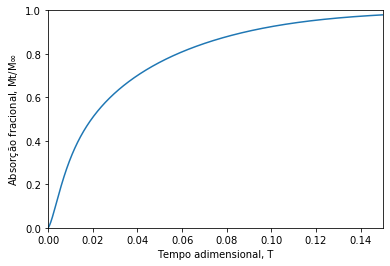

In [15]:
Mt_M = np.zeros_like(T)

for i in range(len(T)):
    Mt_M[i] = simps(C_star[i,:]*R**2,R)/simps(R**2,R)
    
plt.plot(T,Mt_M,'-')
plt.axis([0,0.15,0,1])
plt.xlabel('Tempo adimensional, T')
plt.ylabel('Absorção fracional, Mt/M$\infty$');

Ficou linda! Mas, para realizar uma estimação de parâmetros, essa curva não serve. Precisamos de uma curva experimental. Você dá uma pesquisada na literatura e escolhe a curva  de absorção de sementes mortas de pinhão-manso publicada na Figura 1 de [EVENCIO *et al.* (2011)](http://www.scielo.br/pdf/rarv/v35n2/a03v35n2.pdf).

Como os dados não estão tabelados, e sim disponibilizados na forma de gráfico, você utiliza o aplicativo [WebPlotDigitizer](http://arohatgi.info/WebPlotDigitizer/app/) para obter os pontos e os salva na forma de arquivo csv (*comma separated values*), com o nome **dados_para_humilhar_aquela_ingrata.csv**.

Os dados são importados do arquivo csv por meio da função [genfromtxt](https://docs.scipy.org/doc/numpy/reference/generated/numpy.genfromtxt.html) da biblioteca [NumPy](http://www.numpy.org/): 

In [16]:
dados_pinhao = np.genfromtxt ('dados_para_humilhar_aquela_ingrata.csv', delimiter=",")

Você plota os dados e verifica que estão de acordo com a Figura 1 do [artigo](http://www.scielo.br/pdf/rarv/v35n2/a03v35n2.pdf):

[[ 0.         16.90721649]
 [ 2.9862543  25.56701031]
 [ 6.00114548 29.58762887]
 [ 9.0091638  31.75257732]
 [12.01718213 33.91752577]
 [15.02405498 35.77319588]
 [18.139748   37.15030928]
 [21.03321879 38.24742268]
 [24.03665521 39.17525773]
 [27.04009164 40.10309278]
 [30.1534937  40.92164948]
 [33.15693013 41.64948454]
 [36.04696449 42.15876289]
 [39.16036655 42.87731959]
 [42.1626575  43.42587629]
 [45.27605956 44.01443299]
 [48.1672394  44.43298969]
 [51.16838488 44.76226804]
 [54.16953036 44.95154639]
 [57.28178694 45.20082474]
 [60.28178694 45.46082474]
 [63.17067583 45.55082474]
 [66.17067583 45.60082474]
 [69.17182131 45.67010309]
 [72.28293242 45.67010309]
 [75.39404353 45.67010309]
 [78.17182131 45.67010309]
 [81.28293242 45.67010309]
 [84.28293242 45.67010309]
 [87.28293242 45.67010309]
 [90.28293242 45.67010309]
 [93.28293242 45.67010309]
 [96.28293242 45.67010309]]


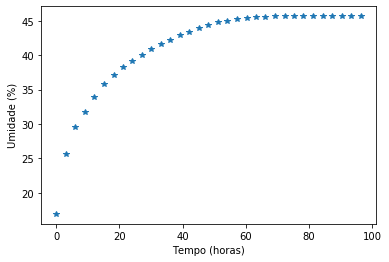

In [17]:
plt.plot(dados_pinhao[:,0],dados_pinhao[:,1],'*')
plt.xlabel('Tempo (horas)')
plt.ylabel('Umidade (%)')

print(dados_pinhao)

Tudo parece estar certo. Antes de realizar a estimação de parâmetros, no entanto, é preciso adaptar os dados. Você transforma a umidade percentual em absorção fracional:

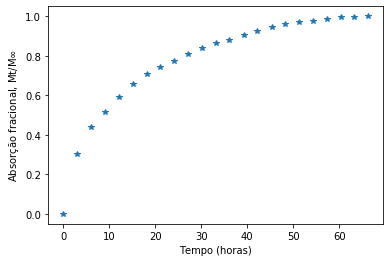

In [18]:
Mt_M_exp = (dados_pinhao[:-10,1]-dados_pinhao[0,1])
Mt_M_exp = Mt_M_exp/Mt_M_exp[-1]
t_exp = dados_pinhao[:-10,0]

plt.plot(t_exp,Mt_M_exp,'*')
plt.xlabel('Tempo (horas)')
plt.ylabel('Absorção fracional, Mt/M$\infty$');

À estimação! O primeiro passo é definir a função objetivo para a estimação, ou seja: uma função em Python que aceite como argumentos os parâmetros $\kappa$, $D_0$ e $\beta$, calcule a curva de absorção fracional $M_t/M_{\infty}$ e retorne a soma dos quadrados das diferenças entre os pontos da curva calculada e da curva experimental. Essa função será fornecida a um método numérico de otimização, que encontrará os valores de $\kappa$, $D_0$ e $\beta$ que minimizam o valor retornado pela função. Se o método funcionar bem, a diferença entre as curvas experimental e calculada será mínima e poderemos dizer que o modelo descreve bem os dados experimentais!

A dita função está definida abaixo:

In [19]:
def Fobj (params):
    
    # parâmetros
    kapa = params[0]
    D0 = params[1]
    beta = params[2]
    
    # concentrações de saturação e inicial
    Cs = 0.456701031
    C0 = 0.169072165

    # raio da semente
    a = 1

    # parâmetros do modelo adimensionalizado
    D0_linha = D0*np.exp(kapa*C0)
    k = kapa*(Cs-C0)
    B = (beta*a**2)/(D0_linha)
    
    # número de pontos na malha
    n = 20
    
    # condição inicial
    S_inicial = np.zeros(n+1)

    # faixa de valores de T em que S será obtida
    T = t_exp*D0_linha/(a**2)

    # integrando!
    sol = odeint(dSdT, S_inicial, T, args=(k,B,n))

    # convertendo S para concentração
    C_star = np.log(k*sol+1)/k

    # criando vetor para grid em R
    R = np.linspace(0,1,n+1)
    
    # calculando a absorção fracional
    
    Mt_M = np.zeros_like(T)
    
    for i in range(len(T)):
        Mt_M[i] = simps(C_star[i,:]*R**2,R)/simps(R**2,R)
        
    # erro (diferença entre as curvas calculada e experimental)
    error = Mt_M - Mt_M_exp
    
    # soma dos quadrados dos erros
    return np.sum(error*error)         

Perceba que a função aceita o vetor **params**, cujos elementos armazenam os valores dos parâmetros $\kappa$, $D_0$ e $\beta$.

Só falta efetuar o cálculo de minimização. Você escolhe para isso o método de minimização [Enxame de Partículas](https://pt.wikipedia.org/wiki/Optimiza%C3%A7%C3%A3o_por_enxame_de_part%C3%ADculas), da biblioteca [PySwarm](https://pythonhosted.org/pyswarm/):

In [20]:
lb = [1e-1, 1e-5, 1e-1]
ub = [2,    1e-1, 3]

alpha_opt, fopt = pso(Fobj, lb, ub)

/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Stopping search: Swarm best objective change less than 1e-08


Imprimindo os parâmetros...

In [21]:
print(alpha_opt)

[0.90398147 0.00331376 0.89957541]


...e o valor da soma dos quadrados da diferença entre as curvas:

In [22]:
print(fopt)

0.008228896206708379


Para finalizar, você plota a curva experimental junto com a calculada:

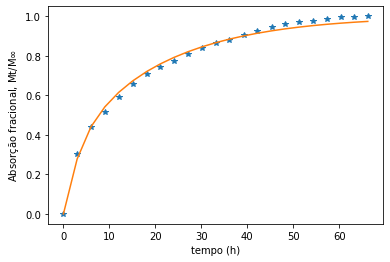

In [23]:
# parâmetros
kapa = alpha_opt[0]
D0 = alpha_opt[1]
beta = alpha_opt[2]

# concentrações de saturação e inicial
Cs = 0.456701031
C0 = 0.169072165

# raio da semente
a = 1

# parâmetros do modelo adimensionalizado
D0_linha = D0*np.exp(kapa*C0)
k = kapa*(Cs-C0)
B = (beta*a**2)/(D0_linha)

# número de pontos na malha
n = 20
    
# condição inicial
S_inicial = np.zeros(n+1)

# faixa de valores de T em que S será obtida
T = t_exp*D0_linha/(a**2)

# integrando!
sol = odeint(dSdT, S_inicial, T, args=(k,B,n))

# convertendo S para concentração
C_star = np.log(k*sol+1)/k

# criando vetor para grid em R
R = np.linspace(0,1,n+1)

# calculando a absorção fracional
    
Mt_M = np.zeros_like(T)
    
for i in range(len(T)):
    Mt_M[i] = simps(C_star[i,:]*R**2,R)/simps(R**2,R)

# plotando    
plt.plot(t_exp,Mt_M_exp,'*',t_exp,Mt_M,'-')
plt.xlabel('tempo (h)')
plt.ylabel('Absorção fracional, Mt/M$\infty$');

Nota-se que a curva calculada pelo modelo parece descrever a tendência dos dados experimentais, apesar de certo distanciamento entre o final da curva e os últimos pontos. Para entender melhor essa questão e avaliar de maneira rigorosa a qualidade dos parâmetros obtidos, seria necessário conhecer os erros experimentais e aplicar técnicas estatísticas para análise dos resultados da estimação, mas esse é assunto para outro notebook.

Um último comentário: se você é atento, percebeu que na Figura 1 do artigo de [EVENCIO *et al.* (2011)](http://www.scielo.br/pdf/rarv/v35n2/a03v35n2.pdf) também há uma curva descrevendo os dados experimentais, cuja equação é:

$$Y = 15{,}0587 - 0{,}370567x + 6{,}72404x^{0{,}5}$$

Os parâmetros $15{,}0587$, $- 0{,}370567$ e $6{,}72404$ devem ter sido obtidos por meio de um procedimento semelhante ao que utilizamos neste *notebook*.

A pergunta que não quer calar: qual a vantagem do nosso complicado modelo em relação à essa singela curva, que possui a mesma quantidade de parâmetros e é muito mais simples?

A vantagem é que nosso modelo possui uma *base teórica forte*. Apesar da maior complexidade, podemos usar o modelo para estudar e entender melhor o processo de absorção, fazer vídeos descrevendo o processo, etc. Além do mais, provavelmente é confiável utilizar nossos parâmetros em condições não muito distantes das do experimento orginal utilizado na estimação. Os parâmetros do [artigo](http://www.scielo.br/pdf/rarv/v35n2/a03v35n2.pdf), por outro lado, provavelmente só podem ser usados estritamente nas condições em que foram estimados, já que o modelo é totalmente empírico e não possui nenhuma base teórica.

## 5. Conclusão

Nova noite de sábado. Você chamou sua amada. Mas dessa vez não há vinhos, não há velas, não há salmão ao molho de maracujá.

Você entrega um papel antes mesmo que ela entre em casa.

&#8212; O que é isso?

&#8212; Uma estimação de parâmetros.

&#8212; Uma o quê?

&#8212; Estimação de parâmetros! Eu não era um idiota? O bobão que não sabia aplicar um simples modelo?

&#8212; Como assim, lindo?

&#8212; Era o que você queria! O modelo aplicado! Dados experimentais! A estimação que eu não sabia fazer! Parece que o jogo virou, não é mesmo? Agora leve isso e dê o fora daqui! Fora daqui!

&#8212; Seu louco! Fanático!

Ela foge, aos prantos. Você cai no sofá, aos prantos. Mais um belo relacionamento que chega ao fim, como acontece a todo momento, em todo lugar. Agora só lhe resta passar a noite assistindo aos seus vídeos que simulam a difusão de água nas mais diversas sementes, ao som de...

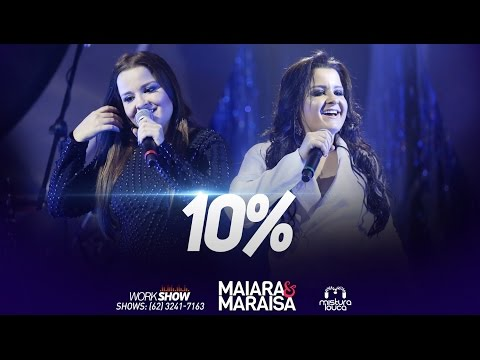

In [24]:
YouTubeVideo("JybMBMTHWP8")

<div style="text-align: right"> Afra </div>

## Referências

[HSU, K. H. - A Diffusion Model with a Concentration-Dependent Diffusion Coefficient for Describing Water Movement in Legumes During Soaking - Journal of Food Science (1983), p. 618-622.](http://www.fcfar.unesp.br/arquivos/560524.pdf)

[EVENCIO, T. *et al.* - Curva de Absorção de Água em Sementes de Pinhão-Manso - Revista Árvore (2011), p. 193-197.](http://www.scielo.br/pdf/rarv/v35n2/a03v35n2.pdf)

[WELTY *et al.* - Fundamentos de Transferência de Momento, de Calor e de Massa - LTC, 6a edição, 2017.](https://www.amazon.com.br/Fundamentos-Transfer%C3%AAncia-Momento-Calor-Massa/dp/8521634188?tag=goog0ef-20&smid=A1ZZFT5FULY4LN&ascsubtag=8521634188)